In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.utils import resample

#For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import itertools

#For model building
import sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#For Metrics evaluation 
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

def normalize_list(input_list):
    min_val = min(input_list)
    max_val = max(input_list)
    
    if min_val == max_val:
        # Handle the case where all values are the same to avoid division by zero
        return [0.0] * len(input_list)
    
    normalized_list = [(x - min_val) / (max_val - min_val) for x in input_list]
    
    return normalized_list

In [2]:
train_data = pd.read_csv('train.csv')

In [3]:
train_data = train_data.drop(['policy_id'], axis=1)

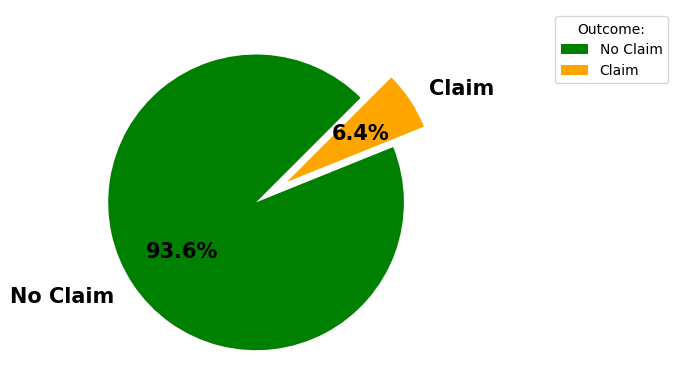

In [4]:
fig = plt.figure(facecolor='white')

ax = fig.add_subplot(1, 1, 1, facecolor='white')

plt.pie(train_data['is_claim'].value_counts(), labels=['No Claim', 'Claim'], radius=1, colors=['green', 'orange'],
        autopct='%1.1f%%', explode=[0.1, 0.15], labeldistance=1.15, startangle=45,
        textprops={'fontsize': 15, 'fontweight': 'bold'})

plt.legend(title='Outcome:', loc='upper right', bbox_to_anchor=(1.6, 1))

fig.patch.set_facecolor('white')

plt.show()

In [5]:
train_data['max_torque'].value_counts()
train_data['torque'] = train_data['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=Nm)', x)[0])
train_data['rpm'] = train_data['max_torque'].apply(lambda x: re.findall(r'\d+\.?\d*(?=rpm)', x)[0])

# Convert the columns to numeric data type
train_data['torque'] = pd.to_numeric(train_data['torque'])
train_data['rpm'] = pd.to_numeric(train_data['rpm'])

# Calculate torque to RPM ratio 
train_data['torque to rpm ratio'] = train_data['torque'] / train_data['rpm']

In [6]:
# Deleting redundant columns from training set
train_data.drop('max_torque', axis=1,inplace=True)
train_data.drop('rpm',axis=1,inplace=True)
train_data.drop('torque',axis=1,inplace=True)

In [7]:
train_data['max_power'].value_counts()

max_power
88.50bhp@6000rpm     17796
40.36bhp@6000rpm     14948
113.45bhp@4000rpm    14018
55.92bhp@5300rpm      4173
67.06bhp@5500rpm      2373
97.89bhp@3600rpm      2114
88.77bhp@4000rpm      1598
61.68bhp@6000rpm      1209
118.36bhp@5500rpm      363
Name: count, dtype: int64

In [8]:
train_data['power'] = train_data['max_power'].apply(lambda x: re.findall(r'\d+\.?\d*(?=bhp)', x)[0])
train_data['rpm'] = train_data['max_power'].apply(lambda x: re.findall(r'\d+', x)[-1])

# Convert the columns to numeric data type
train_data['power'] = pd.to_numeric(train_data['power'])
train_data['rpm'] = pd.to_numeric(train_data['rpm'])

# Calculate power to RPM ratio
train_data['power to rpm ratio'] = train_data['power'] / train_data['rpm']

In [9]:
train_data.drop('power', axis=1,inplace=True)
train_data.drop('rpm',axis=1,inplace=True)
train_data.drop('max_power',axis=1,inplace=True)

In [10]:
is_cols=[col for col in train_data.columns if col.startswith("is") and col!="is_claim"]
print(is_cols)

['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera', 'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer', 'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering', 'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']


In [11]:
train_data = train_data.replace({ "No" : 0 , "Yes" : 1 })

In [12]:
dataset_num_col = train_data.select_dtypes(include=['int', 'float']).columns
print(" Data Set Numerical columns:")
print(dataset_num_col.nunique())
print(dataset_num_col)

 Data Set Numerical columns:
35
Index(['policy_tenure', 'age_of_car', 'age_of_policyholder',
       'population_density', 'make', 'airbags', 'is_esc',
       'is_adjustable_steering', 'is_tpms', 'is_parking_sensors',
       'is_parking_camera', 'displacement', 'cylinder', 'gear_box',
       'turning_radius', 'length', 'width', 'height', 'gross_weight',
       'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
       'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks',
       'is_central_locking', 'is_power_steering',
       'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror',
       'is_ecw', 'is_speed_alert', 'ncap_rating', 'is_claim',
       'torque to rpm ratio', 'power to rpm ratio'],
      dtype='object')


In [13]:
dataset_cat_cols = train_data.select_dtypes(include=['object']).columns
print("Data Set categorical columns:")
print(dataset_cat_cols.nunique())
print(dataset_cat_cols)

Data Set categorical columns:
8
Index(['area_cluster', 'segment', 'model', 'fuel_type', 'engine_type',
       'rear_brakes_type', 'transmission_type', 'steering_type'],
      dtype='object')


In [14]:
train_data= pd.get_dummies(train_data, columns=dataset_cat_cols,drop_first=True)

In [15]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

def balanced_data(X_data, y_data):
    
    minority_class, majority_class = y_data.value_counts().sort_values().values
    print('\033[1m' + "Before Sampling" + '\033[0m')
    print(f"\nShape of the data : {X_data.shape}\n\nValue Counts\n{y_data.value_counts()}")
    
    if (minority_class * 2) > majority_class:
        print("Data is Balanced")
    else:
        print(f"\nData is Imbalanced")
        print('\n\033[1m' + "After Sampling" + '\033[0m\n')
        # 使用RandomUnderSampler進行undersampling
        rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
        X_resampled, y_resampled = rus.fit_resample(X_data, y_data)
        
        # 使用SMOTE進行oversampling
        X_resampled, y_resampled = SMOTE().fit_resample(X_resampled, y_resampled)
        
        print(f"Shape of the data : {X_resampled.shape}\n\nValue Counts\n{y_resampled.value_counts()}")
        
        return X_resampled, y_resampled

y = train_data['is_claim']
train_data, y = balanced_data(train_data, y)


Before Sampling

Shape of the data : (58592, 87)

Value Counts
is_claim
0    54844
1     3748
Name: count, dtype: int64

Data is Imbalanced

After Sampling

Shape of the data : (7496, 87)

Value Counts
is_claim
0    3748
1    3748
Name: count, dtype: int64


In [17]:
X = train_data.drop(['is_claim'], axis=1)  # Features

In [18]:
#分割train:val:test = 8:1:1
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.6,random_state=42,stratify=y)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5,random_state=42,stratify=y_test)

In [19]:
#檢查分割資料數據是否balance
y_train.value_counts(),y_val.value_counts(),y_test.value_counts()

(is_claim
 1    1499
 0    1499
 Name: count, dtype: int64,
 is_claim
 1    1125
 0    1124
 Name: count, dtype: int64,
 is_claim
 0    1125
 1    1124
 Name: count, dtype: int64)

In [20]:
boolean_columns = X_train.select_dtypes(include=['bool']).columns

In [21]:
for i in boolean_columns:
    X_train[i] = X_train[i].astype(int)
    X_val[i] = X_val[i].astype(int)
    X_test[i] = X_test[i].astype(int)

In [22]:
X_train_df = X_train.copy()
X_val_df = X_val.copy()
X_test_df = X_test.copy()

In [23]:
from sklearn.preprocessing import StandardScaler, Normalizer
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)
X_test = StandardScaler().fit_transform(X_test)

###########################第一題###########################

第1次訓練
Training Accuracy: 0.5
第2次訓練
Training Accuracy: 0.7121414276184123
第3次訓練
Training Accuracy: 0.7121414276184123
第4次訓練
Training Accuracy: 0.7114743162108073
第5次訓練
Training Accuracy: 0.7114743162108073
第6次訓練
Training Accuracy: 0.7104736490993996
第7次訓練
Training Accuracy: 0.7108072048032021
第8次訓練
Training Accuracy: 0.709472981987992
第9次訓練
Training Accuracy: 0.709472981987992
第10次訓練
Training Accuracy: 0.7098065376917946
第11次訓練
Training Accuracy: 0.709472981987992
第12次訓練
Training Accuracy: 0.7091394262841895
第13次訓練
Training Accuracy: 0.7084723148765844
第14次訓練
Training Accuracy: 0.7091394262841895
第15次訓練
Training Accuracy: 0.7084723148765844
第16次訓練
Training Accuracy: 0.7078052034689793
第17次訓練
Training Accuracy: 0.7088058705803869
第18次訓練
Training Accuracy: 0.7084723148765844
第19次訓練
Training Accuracy: 0.7084723148765844
第20次訓練
Training Accuracy: 0.7074716477651768
第21次訓練
Training Accuracy: 0.7088058705803869
第22次訓練
Training Accuracy: 0.7078052034689793
第23次訓練
Training Accuracy: 0.706804536

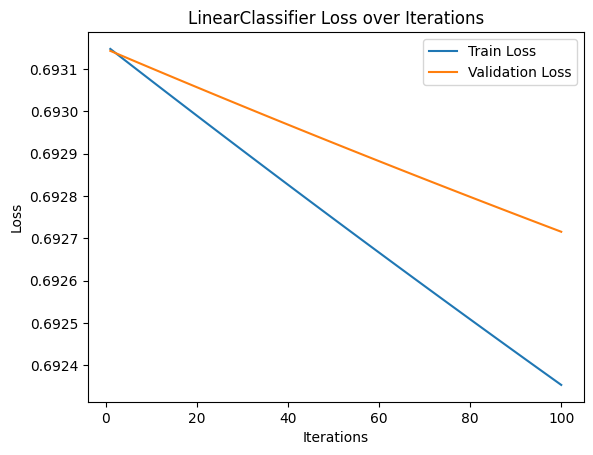

In [28]:
import model
classifier = model.KernelLinearClassifier()
classifier.fit(X_train, y_train, X_val, y_val)
classifier_y_val_pred = classifier.predict(X_val)
print ("\nThe Val Accuracy of our classifier is:", sklearn.metrics.accuracy_score(y_val, classifier_y_val_pred))

classifier_y_test_pred = classifier.predict(X_test)
print ("\nThe Test Accuracy of our classifier is:", sklearn.metrics.accuracy_score(y_test, classifier_y_test_pred))
#classifier.plot_loss(save_path="LinearClassifier_loss_plot.png") 

In [29]:
import model
knn = model.kNN()
knn.fit(X_train, y_train.to_numpy())
knn_y_val_pred = knn.predict(X_val)
print ("\nThe Val Accuracy of our Knn is:", sklearn.metrics.accuracy_score(y_val, knn_y_val_pred))

knn_y_test_pred = knn.predict(X_test)
print ("\nThe Test Accuracy of our Knn is:", sklearn.metrics.accuracy_score(y_test, knn_y_test_pred))


The Val Accuracy of our Knn is: 0.5264562027567808


In [ ]:
#New Feature
X_stacked = np.array([classifier_y_val_pred, knn_y_val_pred]).T

Stacking_tree = model.PruneDecisionTreeClassifier(max_depth=5, min_samples_split=2)  # 設置樹的最大深度
Stacking_tree.fit(X_stacked, y_val)
print("開始預測")
stack_y_val_pred = Stacking_tree.predict(X_stacked)
print ("\nThe Val Accuracy of our new feature is:", sklearn.metrics.accuracy_score(y_val, stack_y_val_pred))

print ("\nThe Val Accuracy of our classifier old feature is:", sklearn.metrics.accuracy_score(y_val, classifier_y_val_pred))
print ("\nThe Val Accuracy of our knn old feature is:", sklearn.metrics.accuracy_score(y_val, knn_y_val_pred))

###########################第二題###########################

In [ ]:
import model
y_train = np.array(y_train)
deep_random_forest = model.DeepRandomForest(num_trees=5, num_features=10, num_instances=50, num_classes=2)
deep_random_forest.train(X_train, y_train)
drf_y_val_pred = deep_random_forest.predict(X_val)
print ("\nThe Val Accuracy of our Knn is:", sklearn.metrics.accuracy_score(y_val, drf_y_val_pred))

drf_y_test_pred = deep_random_forest.predict(X_test)
print ("\nThe Test Accuracy of our Knn is:", sklearn.metrics.accuracy_score(y_test, drf_y_test_pred))

In [ ]:
import model
# 初始化隨機森林模型並擬合數據
rf = model.RandomForest(num_trees=5, num_features=10, num_instances=50, num_classes=2)
rf.fit(X_train, y_train)
rf_y_val_pred = rf.predict(X_val)
print ("\nThe Val Accuracy of our Knn is:", sklearn.metrics.accuracy_score(y_val, rf_y_val_pred))

rf_y_test_pred = rf.predict(X_test)
print ("\nThe Test Accuracy of our Knn is:", sklearn.metrics.accuracy_score(y_test, rf_y_test_pred))

###########################第二題###########################